# **Spark project - Cellitti Francesco, Negroni Edoardo**


# Data Collection

Let's write a Python function that downloads files directly from Github to a directory provided to the function; here we use a **yaml file** as a parameter file to provide global values to the script. In this case, we decided to include the **directories** for the Gas Prices and the Station and Services files, the **first and last** taken into consideration, and the **year** chosen for the Station and Services files.

In [ ]:
# Install the library to work with YAML (YAML Ain't Markup Language) files in Python if needed
!pip install PyYAML

In [ ]:
# Create two folders to store the data in a cleaner way
!mkdir Prices
!mkdir ServicesStations

In [ ]:
# Import the needed libraries
import requests
import os
import gzip
import yaml

# Define the functions
def download_and_extract_gz_file_from_github(filename, destination_dir, github_url=None):
    if github_url is None:
        github_url = f"https://github.com/rvm-courses/GasPrices/raw/master/{filename}"

    response = requests.get(github_url)

    if response.status_code == 200:
        gz_file_path = os.path.join(destination_dir, filename)
        with open(gz_file_path, 'wb') as file:
            file.write(response.content)

        print(f"{filename} downloaded successfully.")

        # Decompress the gzip file
        with gzip.open(gz_file_path, 'rb') as gz_file:
            content = gz_file.read()

        # Write the decompressed content to a new file
        with open(os.path.join(destination_dir, filename[:-3]), 'wb') as new_file:
            new_file.write(content)

        os.remove(gz_file_path)  # Remove the original gzip file
        print(f"{filename} decompressed and saved to {destination_dir}.")
    else:
        print(f"Failed to download {filename}. Status code: {response.status_code}")

def download_gas_prices(config_file):
    for year in range(config['start_year'], config['end_year'] + 1):
        filename = f"Prix{year}.csv.gz"
        download_and_extract_gz_file_from_github(filename, config['data_dir'])

    # Handle special case for 2022
    download_and_extract_gz_file_from_github('Prix2022S1.csv.gz', config['data_dir'])
    download_and_extract_gz_file_from_github('Prix2022S2.csv.gz', config['data_dir'])

def download_stations_files(config_file):
    download_and_extract_gz_file_from_github(f"Stations{config['year_stat_serv']}.csv.gz", config['stations_services_dir'])
    download_and_extract_gz_file_from_github(f"Services{config['year_stat_serv']}.csv.gz", config['stations_services_dir'])

def load_config(config_file):
    with open(config_file, 'r') as file:
        config = yaml.safe_load(file)
    return config

**ATTENTION:** Before running the next cell please load the file "config.yaml" on Google Colab.

In [ ]:
# Load configuration from the YAML file
config = load_config("config.yaml")

print(config)

{'data_dir': '/content/Prices', 'stations_services_dir': '/content/ServicesStations', 'start_year': 2021, 'end_year': 2023, 'year_stat_serv': 2022}


In [ ]:
# Download gas price data for 2021, 2022(two files) and 2023
download_gas_prices(config)

# Download stations and services files for the year 2022
download_stations_files(config)

Prix2021.csv.gz downloaded successfully.
Prix2021.csv.gz decompressed and saved to /content/Prices.
Failed to download Prix2022.csv.gz. Status code: 404
Prix2023.csv.gz downloaded successfully.
Prix2023.csv.gz decompressed and saved to /content/Prices.
Prix2022S1.csv.gz downloaded successfully.
Prix2022S1.csv.gz decompressed and saved to /content/Prices.
Prix2022S2.csv.gz downloaded successfully.
Prix2022S2.csv.gz decompressed and saved to /content/Prices.
Stations2022.csv.gz downloaded successfully.
Stations2022.csv.gz decompressed and saved to /content/ServicesStations.
Services2022.csv.gz downloaded successfully.
Services2022.csv.gz decompressed and saved to /content/ServicesStations.


# Data Preparation

In [ ]:
# Install pyspark if needed
!pip install pyspark

# Import the library
import pyspark

# Start a new session in a variable called spark generally
spark = pyspark.sql.SparkSession.builder.config("spark.executor.memory", "8g").appName("FrancescoTotti").getOrCreate()

spark
# UI graphical interface, how calculations are running with a little trick
# Version
# Master SHOULD BE local. The [*] impplies that is going to use all the possible power (so all the cores)
# App Name:

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=0168e3679046405fe515045e8efbf3baa4e677ecab9094918b3efcb81dbacb3e
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


## Data preparation - Step 1

Let's read all the Gas files:

In [ ]:
from os import listdir
for file in listdir('/content/Prices'):
  globals()[f"{file[:-4]}"] = spark.read.csv('Prices/'+file, sep=';', header=False, inferSchema=True)

In [ ]:
# By using inferSchema (as in the cell above) we're able to save each variable inferring the right type (here is an example)
Prix2021.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: integer (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: timestamp (nullable = true)
 |-- _c6: integer (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: integer (nullable = true)



It's possible to notice that the scale of the prices changes from the first years (2021 are in thousands, while 2022 and 2023 in normal prices), hence we decide to **bring all the values in thousands** to unify everything and because in Spark working with **integers** instead of floats is generally **faster**. The reason behind this is related to the complexity of floating-point arithmetic and the additional precision involved.

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col

# Multiply the values in the "_c8" (Price) column by 1000 for each DataFrame
Prix2022S1 = Prix2022S1.withColumn("_c8", (col("_c8")*1000))
Prix2022S2 = Prix2022S2.withColumn("_c8", (col("_c8")*1000))
Prix2023 = Prix2023.withColumn("_c8", (col("_c8")*1000))

Let's read also Services and Stations files (notice that the separator here is different from the previous case):

In [ ]:
Services = spark.read.csv('ServicesStations/Services2022.csv', sep='|', header=False, inferSchema=True)
Stations = spark.read.csv('ServicesStations/Stations2022.csv', sep='|', header=False, inferSchema=True)

It's time to **merge** the prices for each year (we checked the schema of each variable using .schema before concatenating to ensure that the number of variables and the correspondent types are the same):

In [ ]:
Prices = (Prix2021).union(Prix2022S1).union(Prix2022S2).union(Prix2023)

Let's see how many rows we have now:

In [ ]:
Prices.count()

13910038

In [ ]:
# Change the name of the variables
Prices = Prices.select(col("_c0").alias("id_pdv"),
                       col("_c1").alias("zip_code"),
                       col("_c2").alias("pop"),
                       col("_c3").alias("latitude"),
                       col("_c4").alias("longitude"),
                       col("_c5").alias("date"),
                       col("_c6").alias("gas_id"),
                       col("_c7").alias("gas_label"),
                       col("_c8").alias("prix"))

Split date in year, month, week of the year:

In [ ]:
from pyspark.sql.functions import year, month, weekofyear, day

# Extracting additional date-related information from the 'date' column in the 'Prices' DataFrame
Prices = Prices.withColumn("year", year("date"))
Prices = Prices.withColumn("month", month("date"))
Prices = Prices.withColumn("week_of_year", weekofyear("date"))
Prices = Prices.withColumn("day", day("date"))

Prices = Prices.drop("date")

Prices.show()

+-------+--------+---+---------+---------+------+---------+------+----+-----+------------+---+
| id_pdv|zip_code|pop| latitude|longitude|gas_id|gas_label|  prix|year|month|week_of_year|day|
+-------+--------+---+---------+---------+------+---------+------+----+-----+------------+---+
|1000001|    1000|  R|4620114.0| 519791.0|     1|   Gazole|1252.0|2021|    1|          53|  2|
|1000001|    1000|  R|4620114.0| 519791.0|     1|   Gazole|1268.0|2021|    1|           1|  4|
|1000001|    1000|  R|4620114.0| 519791.0|     1|   Gazole|1268.0|2021|    1|           1|  6|
|1000001|    1000|  R|4620114.0| 519791.0|     1|   Gazole|1268.0|2021|    1|           1|  6|
|1000001|    1000|  R|4620114.0| 519791.0|     1|   Gazole|1273.0|2021|    1|           1|  7|
|1000001|    1000|  R|4620114.0| 519791.0|     1|   Gazole|1274.0|2021|    1|           1|  8|
|1000001|    1000|  R|4620114.0| 519791.0|     1|   Gazole|1277.0|2021|    1|           2| 11|
|1000001|    1000|  R|4620114.0| 519791.0|     1| 

Prepare latitude & longitude for mapping (divide by the right power of 10):

In [ ]:
Prices = Prices.withColumn("latitude", col("latitude")/100000)
Prices = Prices.withColumn("longitude", col("longitude")/10000)

Prices.show()

+-------+--------+---+--------+---------+------+---------+------+----+-----+------------+---+
| id_pdv|zip_code|pop|latitude|longitude|gas_id|gas_label|  prix|year|month|week_of_year|day|
+-------+--------+---+--------+---------+------+---------+------+----+-----+------------+---+
|1000001|    1000|  R|46.20114|  51.9791|     1|   Gazole|1252.0|2021|    1|          53|  2|
|1000001|    1000|  R|46.20114|  51.9791|     1|   Gazole|1268.0|2021|    1|           1|  4|
|1000001|    1000|  R|46.20114|  51.9791|     1|   Gazole|1268.0|2021|    1|           1|  6|
|1000001|    1000|  R|46.20114|  51.9791|     1|   Gazole|1268.0|2021|    1|           1|  6|
|1000001|    1000|  R|46.20114|  51.9791|     1|   Gazole|1273.0|2021|    1|           1|  7|
|1000001|    1000|  R|46.20114|  51.9791|     1|   Gazole|1274.0|2021|    1|           1|  8|
|1000001|    1000|  R|46.20114|  51.9791|     1|   Gazole|1277.0|2021|    1|           2| 11|
|1000001|    1000|  R|46.20114|  51.9791|     1|   Gazole|12

Make data available as a table in order to be able to use Spark SQL:

In [ ]:
Prices.createOrReplaceTempView('price') # Symbolic link and name that we're going to use in SQL

Let's compute the **mean** of the price of each gas type for each year, in order to understand better which gas types have some interest for
the rest of the project:

In [ ]:
prob = spark.sql("""
SELECT year, gas_label, avg(prix) as mean_price
FROM price
GROUP BY gas_label, year
ORDER BY year
""").toPandas()
prob

,year,gas_label,mean_price
0,NaN,None,NaN
1,2021.0,SP98,1640.743507
2,2021.0,E10,1552.410615
3,2021.0,GPLc,877.647703
4,2021.0,SP95,1563.790516
5,2021.0,E85,709.036717
6,2021.0,Gazole,1455.932641
7,2022.0,SP98,1895.908969
8,2022.0,GPLc,861.702517
9,2022.0,Gazole,1875.285474


Let's plot these results obtained to visualize better wether there is any particular pattern:

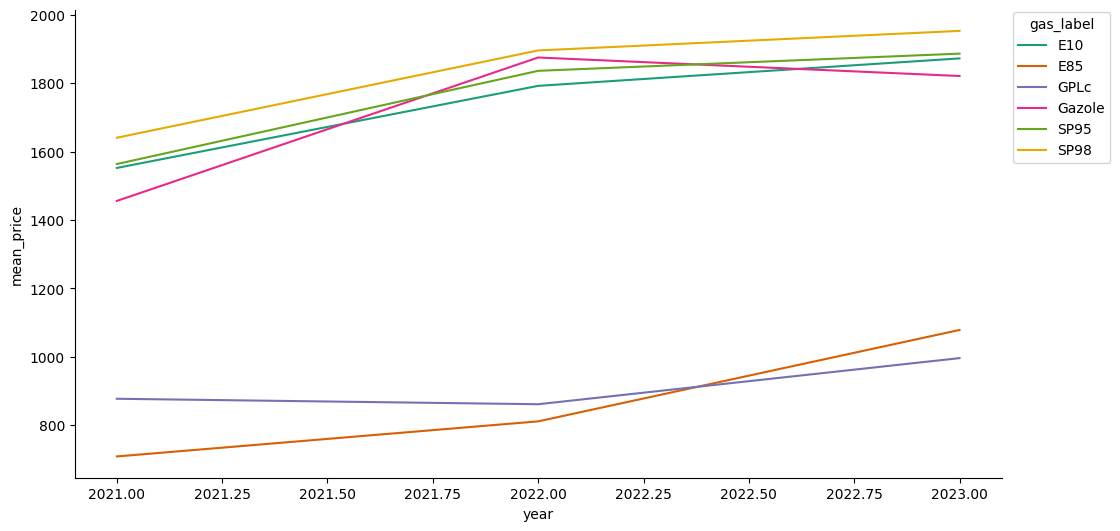

In [ ]:
# Import necessary libraries
from matplotlib import pyplot as plt
import seaborn as sns

# Define a function to plot time series
def _plot_series(series, series_name, series_index=0):
    # Import libraries locally within the function
    from matplotlib import pyplot as plt
    import seaborn as sns

    # Define a color palette for the plot
    palette = list(sns.palettes.mpl_palette('Dark2'))

    # Extract x and y values from the series
    xs = series['year']
    ys = series['mean_price']

    # Plot the series with a specific label and color
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

# Create a subplot for the main plot
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

# Sort the DataFrame by 'year' in ascending order
df_sorted = prob.sort_values('year', ascending=True)

# Iterate over groups based on 'gas_label' and plot each series
for i, (series_name, series) in enumerate(df_sorted.groupby('gas_label')):
    _plot_series(series, series_name, i)

# Add legend to the plot with the title 'gas_label'
fig.legend(title='gas_label', bbox_to_anchor=(1, 1), loc='upper left')

# Remove the spines (the borders) of the plot
sns.despine(fig=fig, ax=ax)

# Set labels for x and y axes
plt.xlabel('year')
_ = plt.ylabel('mean_price')

Let's **drop GPLc and E85**, that shows a big difference in terms of prices (their means are very different from the others) and showing almost a constant behaviour during the years:

In [ ]:
Prices = Prices.filter((Prices["gas_label"] != "E85") & (Prices["gas_label"] != "GPLc"))

## Data preparation - Step 2

Compute a new variable called “Price Index” for each gas type sold in a station such as:

$$
Price Index = 100 × \left(\frac{Day Price In Station - Average Day Price in France}{Average Day Price in France} + 1\right)
$$

Let's compute the average prices per day for each gas type:

In [ ]:
average_prices_df = (Prices
                    .groupBy("year","month","day","gas_label")
                    .agg(F.avg("Prix").alias("AvgDayPriceInFrance")))

In [ ]:
Prices = Prices.join(average_prices_df, ["year", "month", "day","gas_label"], "left_outer")

In [ ]:
#Prices.show()

Now, let's apply the formula written above:

In [ ]:
Prices = (Prices.withColumn("PriceIndex",
                             100 * ((F.col("prix") - F.col("AvgDayPriceInFrance")) / F.col("AvgDayPriceInFrance") + 1)))
#Prices.show()

Compute a new variable called **“Week Index”** for each record counting the number of week since the first week in the file:

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import dense_rank

windowSpec = Window.orderBy("year","week_of_year")
Prices = Prices.withColumn("WeekIndex", dense_rank().over(windowSpec))

Let's drop the original column of the week which we don't need anymore:

In [ ]:
Prices = Prices.drop('week_of_year')

# Data Visualization

In [ ]:
Prices.select('WeekIndex').describe().show()
# Since the maximum is 157 and the weeks are 52/53 per year, having 2021,2022 and 2023 the result is right

+-------+-----------------+
|summary|        WeekIndex|
+-------+-----------------+
|  count|         12066735|
|   mean|79.88197329269268|
| stddev|44.58629006254945|
|    min|                1|
|    max|              157|
+-------+-----------------+



Calculate the **average price for each gas type for each week**:

In [ ]:
from pyspark.sql.functions import avg

average_prices_df = Prices.groupBy("WeekIndex", "gas_label").agg(avg("prix").alias("AvgPrice"))

Represent the **weekly evolution of average gas price over France**:

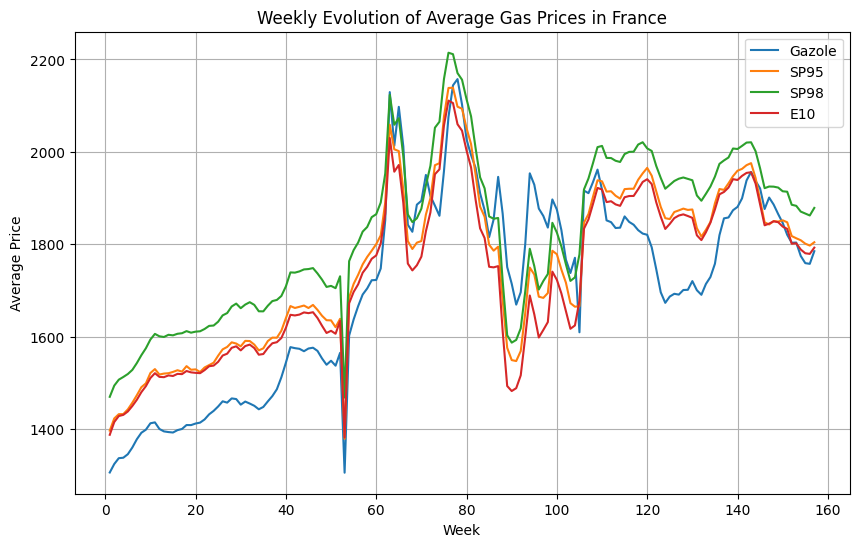

In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame
average_prices_pandas = average_prices_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))

# Loop through each gas type and plot a line
for gas_type in average_prices_pandas["gas_label"].unique():
    gas_type_data = average_prices_pandas[average_prices_pandas["gas_label"] == gas_type]
    plt.plot(gas_type_data["WeekIndex"], gas_type_data["AvgPrice"], label=gas_type)

# Set labels and title
plt.xlabel("Week")
plt.ylabel("Average Price")
plt.title("Weekly Evolution of Average Gas Prices in France")
plt.legend()
plt.grid(True)
plt.show()

It's possible to notice that in the first year (2021) for each gas type the price's trend is about the same, in fact they increase and decrease proportionally to each other. Then, it's evident how at the end of the first year (before the **60th week**) there's a **big drop** for each price's gas type.

In the first semester of 2022, the situation has been less stable (begin of the Ukranian conflict) with a **great increment** of the prices.

Finally, there has been a period (between 80th and 100th week, end of 2022) in which the price of the **Gazole** overcome the Gasoline's one, which was higher for the rest of the study period.


### Represent a map for each gas type of France geo heat maps of price indexes, for example at department level (BONUS QUESTION)

Let's load the Geospatial file in order to build the French map for each department:

In [ ]:
# Geofiles
import geopandas as gpd

url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"

response = requests.get(url)
with open("departements.geojson", "wb") as f:
    f.write(response.content)
france_geo = gpd.read_file("departements.geojson")

france_geo.head()

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ..."
1,02,Aisne,"POLYGON ((4.04797 49.40564, 4.03991 49.39740, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.04907 46.75808, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.69209 44.18648, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.29922 45.10855, ..."


For a better graphical representation let's consider only the average of the prices for 2023:

In [ ]:
# Select only prices for 2023
geod = Prices.select("prix", "gas_label","latitude", "longitude").filter(Prices["year"] == 2023)
geod = geod.toPandas()

from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(geod['longitude'], geod['latitude'])]
gdf = gpd.GeoDataFrame(geod, geometry=geometry)
gdf = gpd.sjoin(gdf, france_geo, how="inner", op="intersects")

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-35-b8cae7bcd51f>:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, france_geo, how="inner", op="intersects")


**Plot for each station the mean price**

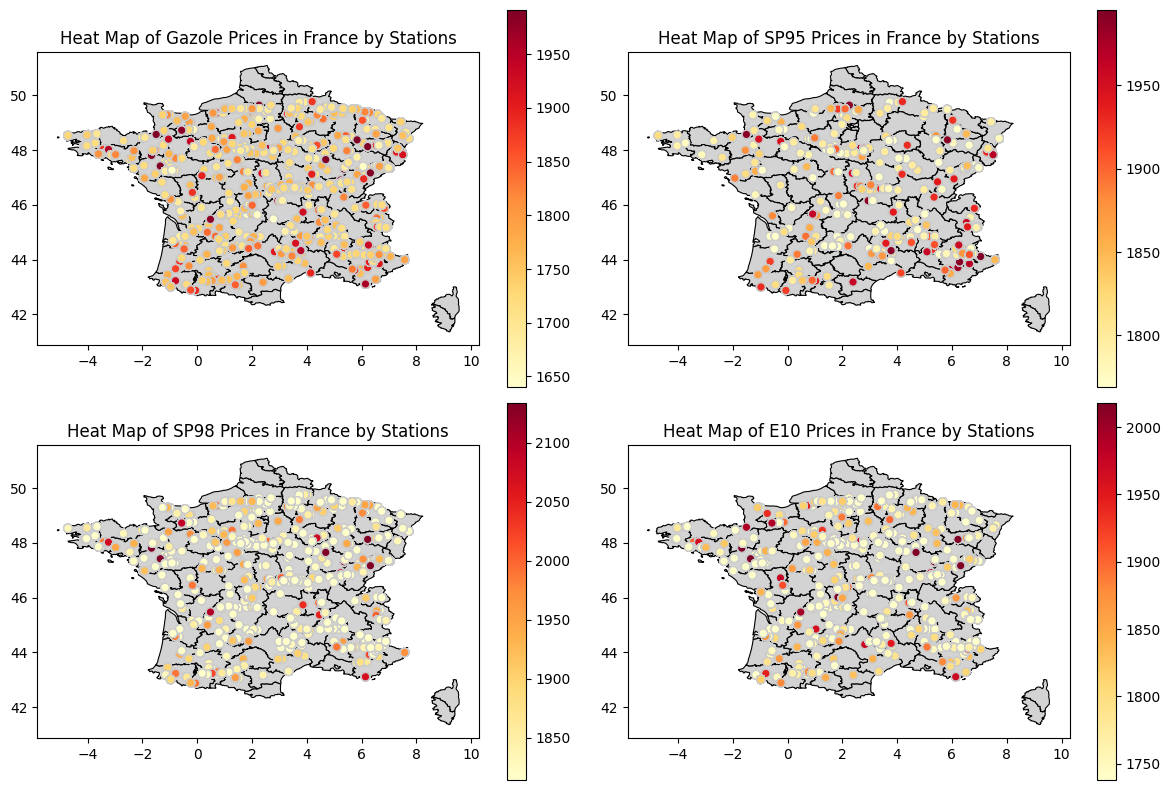

In [ ]:
# Unique gas types
gas_types = average_prices_pandas["gas_label"].unique()

# Create a 2x2 subplot layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Iterate over gas types and plot on each subplot
for idx, gas_type in enumerate(gas_types):
    row = idx // 2  # Row index in the subplot layout
    col = idx % 2   # Column index in the subplot layout

    # Plot base map
    france_geo.plot(color='lightgrey', edgecolor='black', linewidth=0.8, ax=axes[row, col])

    # Filter GeoDataFrame for the current gas type
    filtered_gdf = gdf[gdf['gas_label'] == gas_type]

    # Plot the heatmap for the current gas type
    vmin = geod.loc[geod['gas_label'] == gas_type, 'prix'].quantile(0.05)
    vmax = geod.loc[geod['gas_label'] == gas_type, 'prix'].quantile(0.95)
    filtered_gdf.plot(column='prix', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', legend=True, ax=axes[row, col], vmin=vmin, vmax=vmax)

    # Set the title for the subplot
    axes[row, col].set_title(f"Heat Map of {gas_type} Prices in France by Stations")

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

**Plot for each department the mean price**

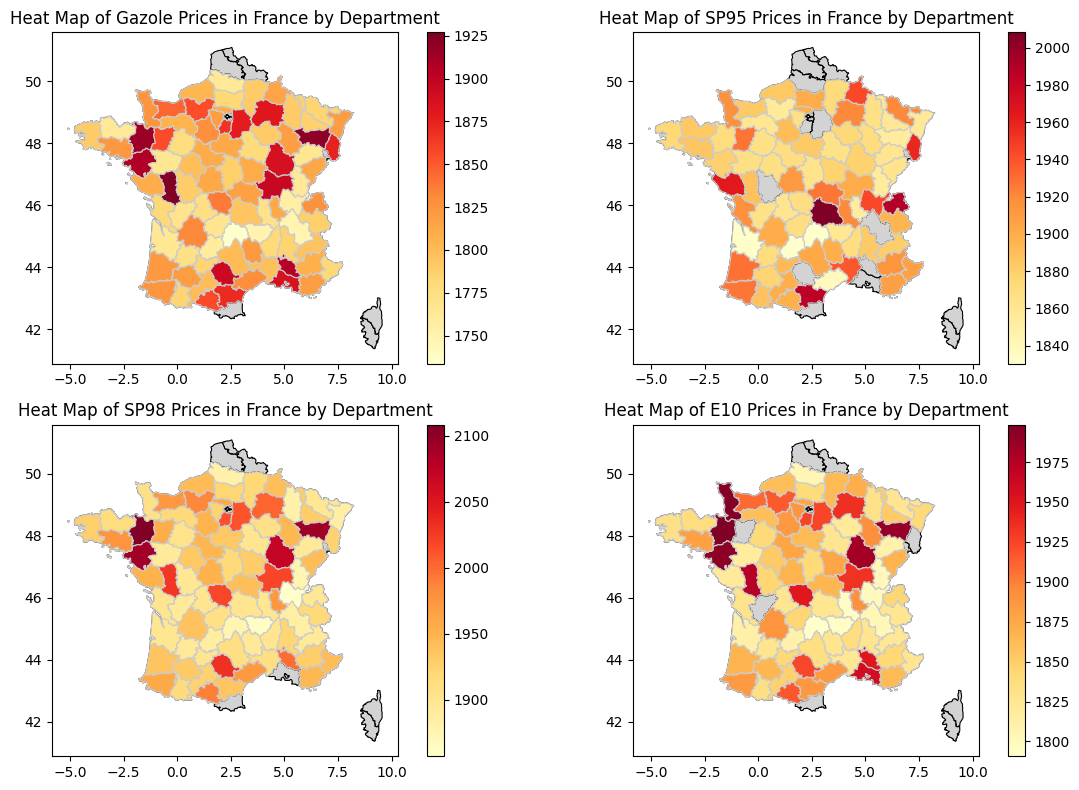

In [ ]:
# Obtain mean values for each department and for each Gas type in 2023
mean_prix_by_department = gdf.groupby(['code', 'gas_label'])['prix'].mean().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Iterate over gas types and plot on each subplot
for idx, gas_type in enumerate(gas_types):

    row = idx // 2  # Row index in the subplot layout
    col = idx % 2   # Column index in the subplot layout

    mean_prix_by_department2 = mean_prix_by_department[mean_prix_by_department['gas_label'] == gas_type]

    # Plot base map
    france_geo.plot(color='lightgrey', edgecolor='black', linewidth=0.8, ax=axes[row, col])

    # Filter GeoDataFrame for the current gas type
    merged_gdf = france_geo.merge(mean_prix_by_department2, on='code', how='left')

    # Plot the heatmap for the current gas type
    merged_gdf.plot(column='prix', cmap='YlOrRd', linewidth=0.8, ax=axes[row, col], edgecolor='0.8', legend=True)

    # Set the title for the subplot
    axes[row, col].set_title(f"Heat Map of {gas_type} Prices in France by Department")

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

In the 2023, it's possible to notice that in the **North-West's** departments the prices for all the gas types are generally higher. Also in the **North-East's** ones it's observed the same pattern but for "SP95".

Instead, in the **South-West** part the prices are generally lower than in the other part of France.

Some departments are colored in **grey** because of the lack of measurements for that department in that year.

# Modeling – Forecast next day price

Build a model based on Spark ML to forecast the next day price for a
gas type in a station.

Let's show the data we have so far:

In [ ]:
Prices.show()

+----+-----+---+---------+-------+--------+---+------------------+---------------+------+------+-------------------+------------------+---------+
|year|month|day|gas_label| id_pdv|zip_code|pop|          latitude|      longitude|gas_id|  prix|AvgDayPriceInFrance|        PriceIndex|WeekIndex|
+----+-----+---+---------+-------+--------+---+------------------+---------------+------+------+-------------------+------------------+---------+
|2021|    1|  7|   Gazole|1390011|    1390|  A|   45.885505980051|48.936217878982|     1|1467.0| 1305.9075720829965|112.33566841641418|        1|
|2021|    1|  7|   Gazole|2000007|    2000|  R|             49.57|          36.21|     1|1266.0| 1305.9075720829965| 96.94407376631244|        1|
|2021|    1|  7|   Gazole|1400001|    1400|  R|            46.119|          49.61|     1|1259.0| 1305.9075720829965| 96.40804808198055|        1|
|2021|    1|  7|   Gazole|1000008|    1000|  R|            46.199|          52.41|     1|1259.0| 1305.9075720829965| 96.4080

Now let's create the **lag features**, which can be very useful and powerful to use in the model.
As pointed out in the paper **"Do We Really Need Deep Learning Models for
Time Series Forecasting?"** (Elsayed, Thyssens, Rashed, Jomaa, Schmidt-Thieme) transforming the time series forecasting task into a window-based regression problem could be more effective than traditional methods and less complex than recent deep learning and matrix factorization models, achieving similar or even better results in terms of accuracy.

We want to create:
* Two lag features for the price, which is the target variable
* One lag feature for the Average Day Price in France and one for the Price Index because we can't use them directly having been computed using the actual price (that is the variable we want to predict), but still they could be interesting so we decided to use their previous value which could give to the model a different measure of the price

In [ ]:
from pyspark.sql.window import Window
#from pyspark.sql import functions as F

# Define the window specification
windowSpec = Window().partitionBy('id_pdv', 'gas_label').orderBy('year', 'month', 'day')

# Create lag features
Prices = Prices.withColumn('lag_prix_1', F.lag('prix', 1).over(windowSpec))
Prices = Prices.withColumn('lag_prix_2', F.lag('prix', 2).over(windowSpec))
Prices = Prices.withColumn('lag_AvgDayPriceInFrance', F.lag('AvgDayPriceInFrance', 1).over(windowSpec))
Prices = Prices.withColumn('lag_PriceIndex', F.lag('PriceIndex', 1).over(windowSpec))

# Drop rows with null values (due to lag)
Prices = Prices.na.drop()

# Show the resulting dataframe
Prices.show()

+----+-----+---+---------+-------+--------+---+--------+---------+------+------+-------------------+-----------------+---------+----------+----------+-----------------------+-----------------+
|year|month|day|gas_label| id_pdv|zip_code|pop|latitude|longitude|gas_id|  prix|AvgDayPriceInFrance|       PriceIndex|WeekIndex|lag_prix_1|lag_prix_2|lag_AvgDayPriceInFrance|   lag_PriceIndex|
+----+-----+---+---------+-------+--------+---+--------+---------+------+------+-------------------+-----------------+---------+----------+----------+-----------------------+-----------------+
|2023|    5| 15|      E10|1000001|    1000|  R|  46.201|    51.98|     5|1791.0| 1831.6320453739809|  97.781648040249|      125|    1803.0|    1779.0|     1827.0964495387195|98.68116160234436|
|2023|    5| 16|      E10|1000001|    1000|  R|  46.201|    51.98|     5|1785.0| 1835.7545252461098|97.23522265378563|      125|    1791.0|    1803.0|     1831.6320453739809|  97.781648040249|
|2023|    5| 19|      E10|1000001| 

It would have been interesting to add more lags, but the models will take a lot of time to run already like that, since we have a lot of data. Hence, for this project we choose to use just these additional features.

Let's see which values assume the **categorical variables** and for the **id_pdv** instead let's count how many different stations we have:

In [ ]:
from pyspark.sql.functions import count
# List of columns that you consider categorical
categorical_columns = ['gas_label', 'id_pdv', 'pop']

# Display unique values and counts for each categorical column
for column in categorical_columns:
    if column == 'id_pdv':
        distinct_values_count = Prices.select(column).distinct().count()
        print(f"Number of distinct values for '{column}': {distinct_values_count}")
    else:
        unique_values = Prices.select(column).distinct().collect()
        print(f"Unique values for '{column}': {', '.join(str(row[column]) for row in unique_values)}")

Unique values for 'gas_label': E10, Gazole, SP95, SP98
Number of distinct values for 'id_pdv': 10218
Unique values for 'pop': R, A, N


Let's create a a restricted dataset for the regression with the variables of interest:

In [ ]:
regr_data = Prices.select('id_pdv', 'zip_code', 'pop','gas_label', 'gas_id', 'prix', 'lag_prix_1', 'lag_prix_2', 'lag_AvgDayPriceInFrance', 'lag_PriceIndex', 'day','month','year')
regr_data.show()

+-------+--------+---+---------+------+------+----------+----------+-----------------------+-----------------+---+-----+----+
| id_pdv|zip_code|pop|gas_label|gas_id|  prix|lag_prix_1|lag_prix_2|lag_AvgDayPriceInFrance|   lag_PriceIndex|day|month|year|
+-------+--------+---+---------+------+------+----------+----------+-----------------------+-----------------+---+-----+----+
|1000001|    1000|  R|      E10|     5|1791.0|    1803.0|    1779.0|     1827.0964495387195|98.68116160234436| 15|    5|2023|
|1000001|    1000|  R|      E10|     5|1785.0|    1791.0|    1803.0|     1831.6320453739809|  97.781648040249| 16|    5|2023|
|1000001|    1000|  R|      E10|     5|1788.0|    1785.0|    1791.0|     1835.7545252461098|97.23522265378563| 19|    5|2023|
|1000001|    1000|  R|      E10|     5|1816.0|    1788.0|    1785.0|      1855.392371377883|96.36775636153797| 22|    5|2023|
|1000001|    1000|  R|      E10|     5|1818.0|    1816.0|    1788.0|     1843.8729542302358| 98.4883473578649| 25|    

Check for **missing values** in each column (to know if in the pipeline we will have to handle them):

In [ ]:
for column in regr_data.columns:
    missing_count = regr_data.filter(regr_data[column].isNull()).count()
    print(f"Number of missing values in '{column}': {missing_count}")

Number of missing values in 'id_pdv': 0
Number of missing values in 'zip_code': 0
Number of missing values in 'pop': 0
Number of missing values in 'gas_label': 0
Number of missing values in 'gas_id': 0
Number of missing values in 'prix': 0
Number of missing values in 'lag_prix_1': 0
Number of missing values in 'lag_prix_2': 0
Number of missing values in 'lag_AvgDayPriceInFrance': 0
Number of missing values in 'lag_PriceIndex': 0
Number of missing values in 'day': 0
Number of missing values in 'month': 0
Number of missing values in 'year': 0


We don't have **missing values**.

Let's check for **outliers** in the prices:

In [ ]:
from pyspark.sql.functions import min, max

# Find the minimum and maximum value in the column "prix"
min_prix = regr_data.select(min("prix")).first()[0]
max_prix = regr_data.select(max("prix")).first()[0]

print(f"Valore minimo di prix: {min_prix}")
print(f"Valore massimo di prix: {max_prix}")

Valore minimo di prix: 1.0
Valore massimo di prix: 9999.0


In [ ]:
# Set a threshold
threshold = 3500

# Filter only the very extreme values
regr_data = regr_data.filter((col("prix") <= threshold) )

Let's build the **Pipeline**:

In [ ]:
# StringIndexer: string -> number
# OneHotEncoder: number -> set of columns

from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.pipeline import Pipeline

# Operation to apply on our table
op_pop = StringIndexer(inputCol='pop', outputCol='npop', handleInvalid='skip')

op_one_gas_id = OneHotEncoder(inputCol='gas_id', outputCol='one_gas_id', dropLast=True)
op_one_pop = OneHotEncoder(inputCol='npop', outputCol='one_pop', dropLast=True)

op_features = VectorAssembler(inputCols=['one_pop', 'one_gas_id', 'lag_prix_1', 'lag_prix_2', 'lag_AvgDayPriceInFrance', 'lag_PriceIndex', 'day','month','year'],
                              outputCol='features') # assembling special requirement of Spark to be more efficient, need all the data (all the columns) packed in one vector

# Chain all the operations together
pipeline_features = Pipeline(stages=[op_pop, op_one_gas_id, op_one_pop, op_features])

Now **apply all the transformations to the data**:

In [ ]:
pipeline_features.fit(regr_data).transform(regr_data).show(5, truncate=False)

+-------+--------+---+---------+------+------+----------+----------+-----------------------+-----------------+---+-----+----+----+-------------+-------------+----------------------------------------------------------------------------------------------------+
|id_pdv |zip_code|pop|gas_label|gas_id|prix  |lag_prix_1|lag_prix_2|lag_AvgDayPriceInFrance|lag_PriceIndex   |day|month|year|npop|one_gas_id   |one_pop      |features                                                                                            |
+-------+--------+---+---------+------+------+----------+----------+-----------------------+-----------------+---+-----+----+----+-------------+-------------+----------------------------------------------------------------------------------------------------+
|1000001|1000    |R  |E10      |5     |1791.0|1803.0    |1779.0    |1827.0964495387195     |98.68116160234436|15 |5    |2023|0.0 |(6,[5],[1.0])|(2,[0],[1.0])|[1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1803.0,1779.0,1827.0964495387

## Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define the Linear Regression model
lr = LinearRegression(labelCol='prix', featuresCol='features', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Build the final pipeline with the linear regression model
pipeline_lr = Pipeline(stages=[pipeline_features, lr])

# Split the data into training and testing sets
train_data, test_data = regr_data.randomSplit([0.8, 0.2], seed=42)

# Fit the pipeline on the training data
fitted_lr = pipeline_lr.fit(train_data)

# Make predictions on the test data
predictions = fitted_lr.transform(test_data)

# Evaluate the model with multiple metrics
evaluator_rmse = RegressionEvaluator(labelCol='prix', predictionCol='prediction', metricName='rmse')
evaluator_r2 = RegressionEvaluator(labelCol='prix', predictionCol='prediction', metricName='r2')

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")
print(f"R-squared (R2) on test data: {r2}")

Root Mean Squared Error (RMSE) on test data: 45.74663083125106
R-squared (R2) on test data: 0.9512030851802438


In [ ]:
predictions.show()

+-------+--------+---+---------+------+------+----------+----------+-----------------------+------------------+---+-----+----+----+-------------+-------------+--------------------+------------------+
| id_pdv|zip_code|pop|gas_label|gas_id|  prix|lag_prix_1|lag_prix_2|lag_AvgDayPriceInFrance|    lag_PriceIndex|day|month|year|npop|   one_gas_id|      one_pop|            features|        prediction|
+-------+--------+---+---------+------+------+----------+----------+-----------------------+------------------+---+-----+----+----+-------------+-------------+--------------------+------------------+
|1000001|    1000|  R|      E10|     5|1759.0|    1778.0|    1802.0|     1811.3745800671893| 98.15749981067134| 20|   11|2023| 0.0|(6,[5],[1.0])|(2,[0],[1.0])|[1.0,0.0,0.0,0.0,...|1787.0538996796458|
|1000001|    1000|  R|      E10|     5|1774.0|    1751.0|    1767.0|     1787.0983563788157| 97.98005765883185| 18|   12|2023| 0.0|(6,[5],[1.0])|(2,[0],[1.0])|[1.0,0.0,0.0,0.0,...|1757.5927606322084|


Let's have a look at the **coefficients** of the model:

In [ ]:
# Get the linear regression model from the pipeline
lr_model = fitted_lr.stages[-1]

# Extract coefficients and intercept
coefficients = lr_model.coefficients
intercept = lr_model.intercept

# Create a list of feature names from the VectorAssembler output
#feature_names = pipeline_features.getStages()[-1].getInputCols()

# Display the intercept
print(f"Intercept: {intercept}")

feature_names = [
    "pop_R",
    "pop_A",
    "pop_N",
    "E10",
    "Gazole",
    "SP95",
    "SP98",
    'lag_prix_1',
    'lag_prix_2',
    'lag_AvgDayPriceInFrance',
    'lag_PriceIndex',
    'day',
    'month',
    'year'
]

# Display coefficients for each feature
for feature, coef in zip(feature_names, coefficients):
    print(f"Coefficient for {feature}: {coef}")

Intercept: -4191.76494340364
Coefficient for pop_R: -11.127699927163707
Coefficient for pop_A: 11.10956372943812
Coefficient for pop_N: 0.0
Coefficient for E10: -0.3687598212542981
Coefficient for Gazole: 1.3794989513148925
Coefficient for SP95: 0.0
Coefficient for SP98: 0.0
Coefficient for lag_prix_1: -0.5991509539838588
Coefficient for lag_prix_2: 0.33479668440884597
Coefficient for lag_AvgDayPriceInFrance: 0.29326255428058484
Coefficient for lag_PriceIndex: 0.35428947629346996
Coefficient for day: 3.5252471380534316
Coefficient for month: 0.0
Coefficient for year: -0.9311011536984665


- These coefficients represent the change in the dependent variable for each category compared to the baseline category (which is 'pop_N' in this case), so if it is from a rural area the price is 11 millieuros less w.r.t 'N area'.

- With respect to SP95, SP98 might have the same characteristics.

- A one millieuro increase in 'lag_prix_1' is associated with a decrease of approximately 0.59 millieuros in the dependent variable (assuming other variables are constant).

- A one millieuro increase in 'lag_prix_2' is associated with an increase of approximately 0.33 one millieuros in the dependent variable (assuming other variables are constant).

Dispersion plot between actual & forecast:

In [ ]:
actual_and_predictions = predictions.select('prix', 'prediction').toPandas()

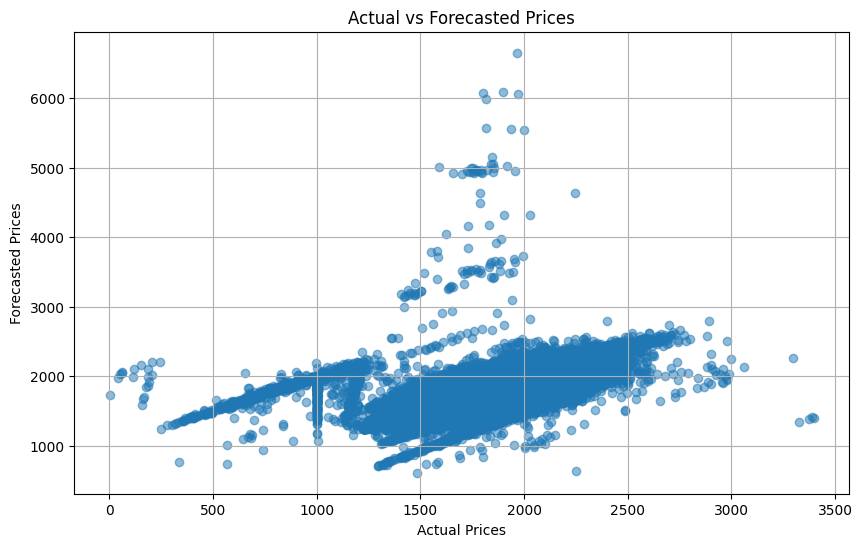

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(actual_and_predictions['prix'], actual_and_predictions['prediction'], alpha=0.5)
plt.title('Actual vs Forecasted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Forecasted Prices')
plt.grid(True)
plt.show()

This plot represents the actual prices compared with forecasted ones, showing some problems for few estimates (100 values over 12.000.000 out of the interval).

## Gradient-Boosted Trees

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Split the data into training and testing sets
train_data, test_data = regr_data.randomSplit([0.8, 0.2], seed=42)

# Define the GBT model
gbt = GBTRegressor(labelCol='prix', featuresCol='features', maxIter=10, maxDepth=5, seed=42)

# Build the final pipeline with the GBT model
pipeline_gbt = Pipeline(stages=[pipeline_features, gbt])

# Fit the pipeline on the training data
fitted_gbt = pipeline_gbt.fit(train_data)

# Make predictions on the test data
predictions_gbt = fitted_gbt.transform(test_data)

# Evaluate the GBT model with multiple metrics
evaluator_rmse_gbt = RegressionEvaluator(labelCol='prix', predictionCol='prediction', metricName='rmse')
evaluator_r2_gbt = RegressionEvaluator(labelCol='prix', predictionCol='prediction', metricName='r2')

rmse_gbt = evaluator_rmse_gbt.evaluate(predictions_gbt)
r2_gbt = evaluator_r2_gbt.evaluate(predictions_gbt)

print(f"GBT - Root Mean Squared Error (RMSE) on test data: {rmse_gbt}")
print(f"GBT - R-squared (R2) on test data: {r2_gbt}")

GBT - Root Mean Squared Error (RMSE) on test data: 39.74987284297633
GBT - R-squared (R2) on test data: 0.9631577942875973


In [ ]:
predictions_gbt.show()

+-------+--------+---+---------+------+------+----------+----------+-----------------------+------------------+---+-----+----+----+-------------+-------------+--------------------+------------------+
| id_pdv|zip_code|pop|gas_label|gas_id|  prix|lag_prix_1|lag_prix_2|lag_AvgDayPriceInFrance|    lag_PriceIndex|day|month|year|npop|   one_gas_id|      one_pop|            features|        prediction|
+-------+--------+---+---------+------+------+----------+----------+-----------------------+------------------+---+-----+----+----+-------------+-------------+--------------------+------------------+
|1000001|    1000|  R|      E10|     5|1759.0|    1778.0|    1802.0|     1811.3745800671893| 98.15749981067134| 20|   11|2023| 0.0|(6,[5],[1.0])|(2,[0],[1.0])|[1.0,0.0,0.0,0.0,...| 1771.520987960363|
|1000001|    1000|  R|      E10|     5|1774.0|    1751.0|    1767.0|     1787.0983563788157| 97.98005765883185| 18|   12|2023| 0.0|(6,[5],[1.0])|(2,[0],[1.0])|[1.0,0.0,0.0,0.0,...|1741.4064682281703|


Let's have a look at the **feature importance** plot:

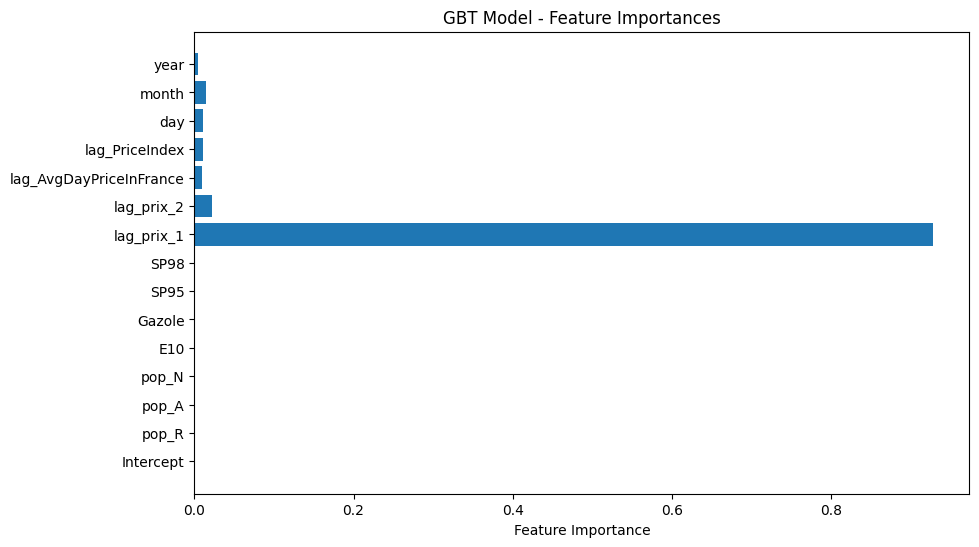

In [ ]:
from pyspark.ml.regression import GBTRegressionModel
import matplotlib.pyplot as plt

# Get the GBT model from the pipeline
gbt_model = fitted_gbt.stages[-1]

feature_names = [
    "Intercept",
    "pop_R",
    "pop_A",
    "pop_N",
    "E10",
    "Gazole",
    "SP95",
    "SP98",
    'lag_prix_1',
    'lag_prix_2',
    'lag_AvgDayPriceInFrance',
    'lag_PriceIndex',
    'day',
    'month',
    'year'
]

# Ensure that the GBT model is an instance of GBTRegressionModel
if isinstance(gbt_model, GBTRegressionModel):
    # Extract feature importances
    feature_importances = gbt_model.featureImportances.toArray()

    # Create a list of feature names from the VectorAssembler output
    #feature_names = pipeline_features.getStages()[-1].getInputCols()

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importances)), feature_importances, align='center')
    plt.yticks(range(len(feature_importances)), feature_names)
    plt.xlabel('Feature Importance')
    plt.title('GBT Model - Feature Importances')
    plt.show()
else:
    print("The fitted model is not a GBT Regression Model.")


As expected the variable of the price at time t-1 represents the most important, followed by the one at time t-2.

In [ ]:
feature_importances = fitted_gbt.stages[-1].featureImportances

# Print feature importances
print("GBT - Feature Importances:")
for i, importance in enumerate(feature_importances):
    print(f"Feature {feature_names[i]}: {importance}")

GBT - Feature Importances:
Feature Intercept: 0.0002448567276622165
Feature pop_R: 0.0
Feature pop_A: 0.0
Feature pop_N: 0.000474650906127772
Feature E10: 0.0
Feature Gazole: 0.0
Feature SP95: 0.0
Feature SP98: 0.0003550548798759832
Feature lag_prix_1: 0.927997064926483
Feature lag_prix_2: 0.02238554534806831
Feature lag_AvgDayPriceInFrance: 0.009825073969586722
Feature lag_PriceIndex: 0.01027306466312335
Feature day: 0.010200703413506727
Feature month: 0.014427578836404702
Feature year: 0.0038164063291612413


Dispersion plot between actual & forecast:

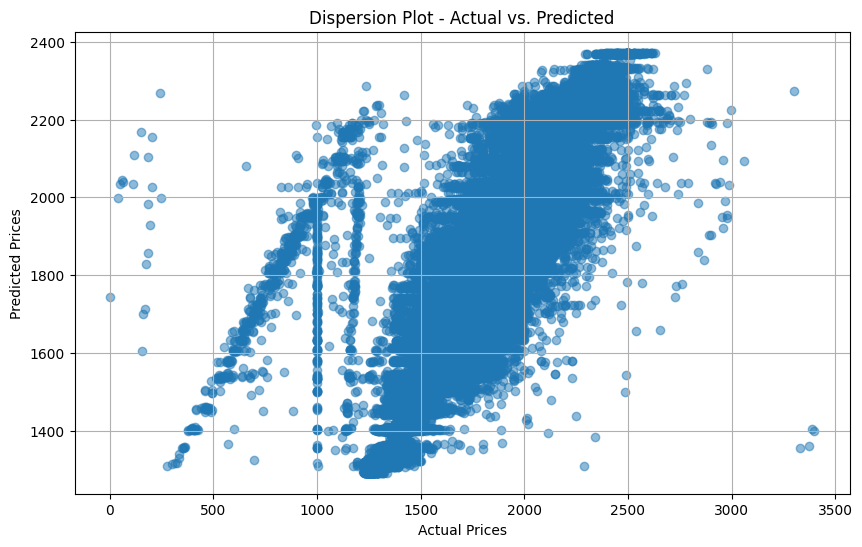

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col

# Extract actual and predicted values from the PySpark DataFrame
actual_values = predictions_gbt.select("prix").toPandas()["prix"]
predicted_values = predictions_gbt.select("prediction").toPandas()["prediction"]

# Create a dispersion plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.title('Dispersion Plot - Actual vs. Predicted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.show()

Even if we notice a strange pattern in the left side, the majority of the observations seem to be predicted good.

## Remarks and conclusions

The **final results** obtained by applying two different regression models, **Linear Regression** and **Gradient-Boosted Trees**, are:

- **LR** : Root Mean Squared Error (RMSE) on test data: 45.746, R-squared (R2) on test data: 0.951.
- **GBT** : Root Mean Squared Error (RMSE) on test data: 39.749, R-squared (R2) on test data: 0.963.

For the sake of completeness, we want to point out that although only the above results were shown in this notebook with this pipeline for reasons of space and running time, several tests were performed by **varying the pipeline** before fitting the model for a more thorough analysis. All of them were performed only with the GBT model since it was the one achieving the best result with the first pipeline (but also more time-consuming). The following are the **tests** performed:

- **1st Test** : Same pipeline but without the variables "day", "month" and "year" (since the data were already ordered by "id_pdv" and those three variables) --> **Result** : the time needed was the same (51 min) and the RMSE on the same test data was 44.127 (slightly worse).
- **2nd Test** : Same pipeline as in the 1st Test but without doing the one-hot encoding (so just using StringIndexer and VectorAssembler), since the trees can deal with categorical variables --> **Result** : the time needed was slightly better but not so significantly (45 min) and the RMSE was exactly the same as in the 1st Test.
- **3rd Test** : Same pipeline as in the 2nd Test adding the variable "id_pdv" (id of the station) to see wether that variable could be useful --> **Result** : the time needed was almost the same as in 1st Test, with an imperceptible improvement in the RMSE on the test data that was 43.998.
